In [ ]:
!pip install -q llama-hub-youtube-transcript llama-index-readers-youtube-transcript groq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.8 MB/s eta 0:00:00


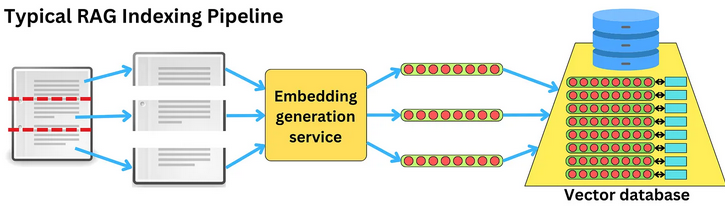

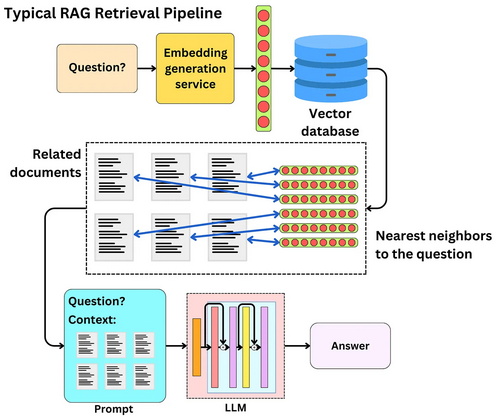

https://images.app.goo.gl/ZenPjqaqQ5f7LsB97

Use-Cases and benifits of RAG: [blog](https://www.databricks.com/glossary/retrieval-augmented-generation-rag)

In [ ]:
import numpy as np
import pandas as pd
from llama_index.readers.youtube_transcript import YoutubeTranscriptReader
from groq import Groq

from google.colab import userdata
import os
from groq import Groq

from sentence_transformers import SentenceTransformer

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
def get_response_from_groq(system_role, user_message, **kwargs):
    client = Groq()

    model = kwargs.get("model", "llama3-8b-8192")
    temperature = kwargs.get("temperature", 1)
    max_tokens = kwargs.get("max_tokens", 1024)
    top_p = kwargs.get("top_p", 1)
    stop = kwargs.get("stop", None)

    messages = [
        {
            "role": "system",
            "content": system_role
        },
        {
            "role": "user",
            "content": user_message
        }
    ]

    completion = client.chat.completions.create(
          model=model,
          messages=messages,
          temperature=temperature,
          max_tokens=max_tokens,
          top_p=top_p,
          stop=stop
      )

    response = completion.choices[0].message.content
    return response

In [ ]:
response = get_response_from_groq("", "What is are the power and torque figures of tata curvv")

print(response)

I apologize, but there is no such car as the "Tata Curvv". Tata Motors is an Indian automobile manufacturer that has produced many popular cars, SUVs, and electric vehicles, but "Curvv" is not one of them.

If you meant to ask about a different car or a concept car, please let me know and I'll be happy to help. Alternatively, if you're interested in knowing the specifications of a particular Tata car, please provide the name of the car you're interested in, and I'll do my best to provide you with the accurate power and torque figures.


### Load Data

In [ ]:
# We will read the youtube revies and use them as context to improve our response
loader = YoutubeTranscriptReader()
documents = loader.load_data(
    ytlinks=["https://youtu.be/VS47A-vTZ34?si=1YntVAf2n8lRoj5R",
             "https://youtu.be/JhDSjZxOaek?si=2ITod5ENzDVCFxMo",
             "https://youtu.be/Ed11kH3Ypq0?si=HGklEugqg5EH72a-"]
)

### Tokenizer

In [ ]:
import tiktoken

In [ ]:
model = "cl100k_base"

encoding = tiktoken.get_encoding(model)

token_numbers = encoding.encode("tiktoken is great!")

token_numbers

[83, 1609, 5963, 374, 2294, 0]

In [ ]:
for token_number in token_numbers:
    print(f"{token_number}: {encoding.decode([token_number])}")

83: t
1609: ik
5963: token
374:  is
2294:  great
0: !


In [ ]:
# Count the number of tokens in text
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string("tiktoken is great!")

6

### Inspect data

In [ ]:
documents[2].text

"This SUV saved my life gattle decided to\nsay hi in the middle of a highway the XV\n7's Ada system woke up from 80 km an\nhour break all the way down to a\nstandstill and saved my\nlife no I'm not being dramatic it was\njust one of those moments where it is\nout of your control but not for the XUV\n7o ads as I've said earlier is a very\nnice nice feature to have and the XV 7o\nAA system did save my\nlife I'm sure you've seen a lot of these\nacross the country by now Mahindra\nrolled out 2 lakh units of the XUV 7o\nsince\nlaunch which was just 3 years\nago you might think a lot of cars have\nbeen doing that however how many of them\ntruly come with Adas this is worldclass\ntechnology act inside the XV\n7o and that's not the only\nthing you have Alexa smartphone\nconnectivity climate control a giant\ndual screen dashboard setup with adreno\nX powering it a huge skyroof and so much\nmore coming to the Interiors of the XV 7\nbelow it surrounds you in one of the\nmost luxurious cabins of t

In [ ]:
# number of tokens in each document
for document in documents:
    print(num_tokens_from_string(document.text))

4284
10259
582


### Create chunks

In [ ]:
full_text = "\n\n".join([document.text for document in documents])

num_tokens_from_string(full_text)

15126

In [ ]:
# Lets chunk the text such that each chunk has 512 tokens with an overlap of 50 tokens between the chunks.

chunk_size = 1024
overlap = 128

def get_token_encoding(text):
    encoding = tiktoken.get_encoding("cl100k_base")
    tokens = encoding.encode(text)
    return tokens

def chunk_text(text, chunk_size, overlap):
    chunks = []
    current_chunk = ""

    tokens = get_token_encoding(text)

    # print(len(tokens))
    # print([i for i in range(0, len(tokens), chunk_size - overlap)])

    # perfom chunking with overlap
    for i in range(0, len(tokens), chunk_size - overlap):
        chunk = tokens[i : i + chunk_size]
        chunk_text = encoding.decode(chunk)
        chunks.append(chunk_text)

    return chunks

In [ ]:
chunk_text("this is an awesome tool!, I'm using tiktoken to encode the english text", 4, 2)

['this is an awesome',
 ' an awesome tool!,',
 " tool!, I'm",
 " I'm using tik",
 ' using tiktoken to',
 'token to encode the',
 ' encode the english text',
 ' english text']

In [ ]:
ytdata_chunks = chunk_text(full_text, chunk_size, overlap)
len(ytdata_chunks)

17

### Sentence embeddings

In [ ]:
# Load model to encode data
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(sentences)
print(embeddings)

[[ 0.0225026  -0.0782918  -0.02303076 ... -0.00827925  0.02652694
  -0.00201898]
 [ 0.04170239  0.00109739 -0.01553419 ... -0.02181625 -0.06359357
  -0.00875283]]


In [ ]:
len(embeddings[0])

768

In [ ]:
# Create sentence embedding for each of the chunk
chunk_embeddings = model.encode(ytdata_chunks)

In [ ]:
chunk_embeddings_list = []
for i in range(len(chunk_embeddings)):
  encoding_dict = {"id": i, "text": ytdata_chunks[i], "embedding": chunk_embeddings[i]}
  chunk_embeddings_list.append(encoding_dict)


In [ ]:
# chunk_embeddings_list[0]

### Cosine similarity

In [ ]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

cosine_similarity(model.encode("this is a sunny day"),model.encode("students are playing"))

0.089407414

In [ ]:
def get_top_k_similar_chunks(query, embeddings, k=3):
  query_embedding = model.encode(query)
  chunk_similarities = []
  for chunk in embeddings:
    chunk_similarities.append(cosine_similarity(query_embedding, chunk["embedding"]))

  # get top k similar text embeddings
  chunk_similarities = np.array(chunk_similarities)
  top_k_indices = np.argsort(chunk_similarities)[-k:]
  return [{**embeddings[i], "similarity": chunk_similarities[i]} for i in top_k_indices]


In [ ]:
top_matches = get_top_k_similar_chunks("Tell about curvv ev", chunk_embeddings_list)

for i in top_matches:
  print(f"chunk_id: {i['id']}, similarity: {i['similarity']}")

chunk_id: 5, similarity: 0.3346980810165405
chunk_id: 8, similarity: 0.35488569736480713
chunk_id: 16, similarity: 0.3958451449871063


In [ ]:
len(chunk_embeddings_list)

17

### Use similar text for generating data

In [ ]:
system_prompt = """You are a helpful assistant, answer the question asked by user using the below context.
If the context does not contain the answer to the question asked by user, respond that you do not know.

context: {context}
"""

def get_response_using_rag(user_message, **kwargs):
  k = kwargs.get("k", 3)
  top_matches = get_top_k_similar_chunks(user_message, chunk_embeddings_list, k)

  context = "\n\n".join([i["text"] for i in top_matches])

  print("similar chunk ids: ",[(i["id"], i["similarity"]) for i in top_matches], "\n\n\n")

  system_prompt_with_context = system_prompt.format(context=context)

  return get_response_from_groq(system_role=system_prompt_with_context, user_message=user_message)

In [ ]:
response = get_response_using_rag("What are the power figures of tata curv")

print(response)

similar chunk ids:  [(2, 0.43830577), (0, 0.513042), (3, 0.5137821)] 



According to the text, the Tata Curve has three engine options:

1. The base engine is Tata's familiar 1.2 L 3-cylinder Revotron turbo petrol engine, which makes 120 horsepower and 170 Nm.
2. The next option is the new 1.2 L 3-cylinder direct injection turbo petrol engine branded Hyperion, which produces 125 horsepower and 225 Nm.
3. The third option is the 1.5 L 4-cylinder diesel engine, which makes 118 horsepower and 260 Nm.

Note that these are the power figures mentioned in the text, and it's possible that there may be other engine options or power figures available in different markets or trim levels.


## Task

There may be cases where user wants to ask follow-up questions based on the previous response, how would you handle this situation?

The model needs to remember it's previous question, response and context to answer the new question.
Implement a tool that responds to users using RAG and also supports follow-up questions. Keep in mind the drawbacks of having [long context window](https://www.linkedin.com/pulse/understanding-context-window-large-language-models-llms-yeshwanth-mklac).

Hint: You can first classify the user prompt whether it is a followup question or a new question and decide whether or not to pass the history.  